In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout




In [5]:
df = pd.read_csv('powerdemand_5min_2021_to_2024_with weather.csv', parse_dates=['datetime'], index_col='datetime')

df.head()

,Unnamed: 0,Power demand,temp,dwpt,rhum,wdir,wspd,pres,year,month,day,hour,minute,moving_avg_3
datetime,,,,,,,,,,,,,,
2021-01-01 00:30:00,0,2014.00,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,30,NaN
2021-01-01 00:35:00,1,2005.63,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,35,NaN
2021-01-01 00:40:00,2,1977.60,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,40,1999.076667
2021-01-01 00:45:00,3,1976.44,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,45,1986.556667
2021-01-01 00:50:00,4,1954.37,8.0,6.9,93.0,0.0,0.0,1017.0,2021,1,1,0,50,1969.470000


In [6]:
df = df.resample('h').mean()  # If you want hourly data instead of 5-min

# Fill missing values
df = df.interpolate(method='time')

# Optional: feature engineering
df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month

# Suppose dataset has load column called 'demand' and weather like 'temperature', 'humidity'
features = ['Power demand', 'temp', 'rhum', 'hour', 'day', 'month']
data = df[features]

# Scaling
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data)

In [7]:
def create_sequences(data, target_idx, window_size=24):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, :])
        y.append(data[i, target_idx])
    return np.array(X), np.array(y)

window_size = 24  # using past 24 hours to predict next
target_col = features.index('Power demand')

X, y = create_sequences(data_scaled, target_idx=target_col, window_size=window_size)

In [8]:
split_ratio = 0.8
split = int(len(X) * split_ratio)

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("X_train shape:", X_train.shape, "X_test shape:", X_test.shape)

X_train shape: (27648, 24, 6) X_test shape: (6913, 24, 6)


In [9]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

C:\Users\NIKITA CHAUHAN\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,289 (79.25 KB)

 Trainable params: 20,289 (79.25 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    shuffle=False
)

Epoch 1/20
692/692 ━━━━━━━━━━━━━━━━━━━━ 17s 17ms/step - loss: 0.0145 - mae: 0.0915 - val_loss: 0.0067 - val_mae: 0.0613
Epoch 2/20
692/692 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0052 - mae: 0.0542 - val_loss: 0.0038 - val_mae: 0.0447
Epoch 3/20
692/692 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0036 - mae: 0.0442 - val_loss: 0.0025 - val_mae: 0.0355
Epoch 4/20
692/692 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 0.0026 - mae: 0.0362 - val_loss: 0.0028 - val_mae: 0.0391
Epoch 5/20
692/692 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0021 - mae: 0.0318 - val_loss: 0.0026 - val_mae: 0.0374
Epoch 6/20
692/692 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0018 - mae: 0.0290 - val_loss: 0.0043 - val_mae: 0.0533
Epoch 7/20
692/692 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 0.0018 - mae: 0.0284 - val_loss: 0.0027 - val_mae: 0.0402
Epoch 8/20
692/692 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0016 - mae: 0.0261 - val_loss: 0.0031 - val_mae: 0.0442
Epoch 9/20
692/692 ━━━━━━━━━━━━━━━━━━━━ 

In [11]:
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print("Test MSE:", mse)
print("Test MAE:", mae)

217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
Test MSE: 0.007347564254001369
Test MAE: 0.07332535483670836


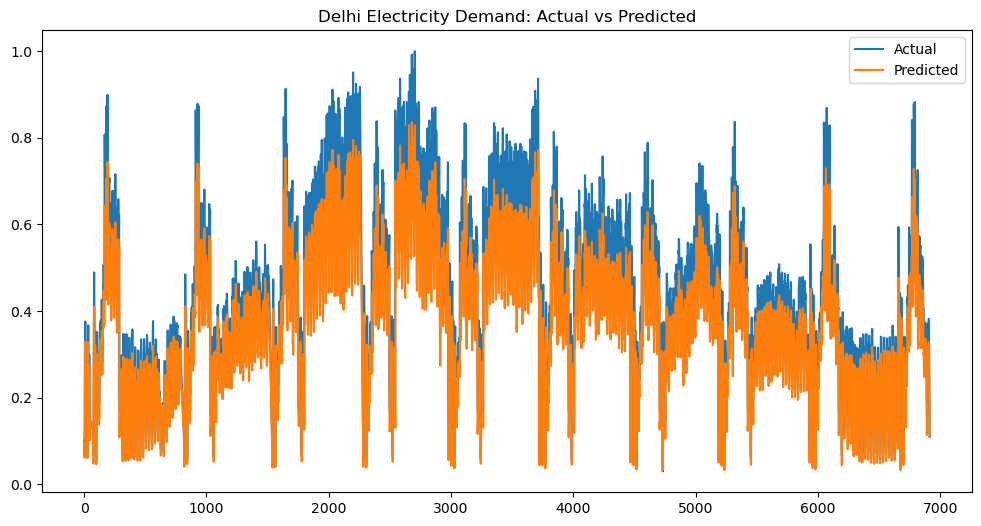

In [12]:
plt.figure(figsize=(12,6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('Delhi Electricity Demand: Actual vs Predicted')
plt.show()

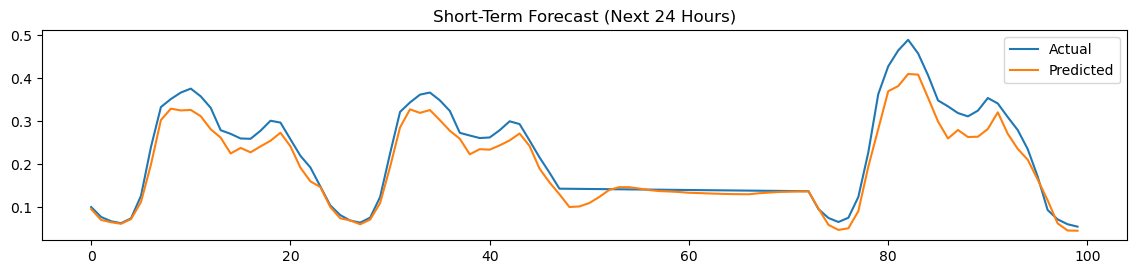

In [13]:
plt.figure(figsize=(14,6))

# Short-Term (first 100 hours for clarity)
plt.subplot(2,1,1)
plt.plot(y_test[:100].flatten(), label="Actual")
plt.plot(y_pred[:100].flatten(), label="Predicted")
plt.title("Short-Term Forecast (Next 24 Hours)")
plt.legend()

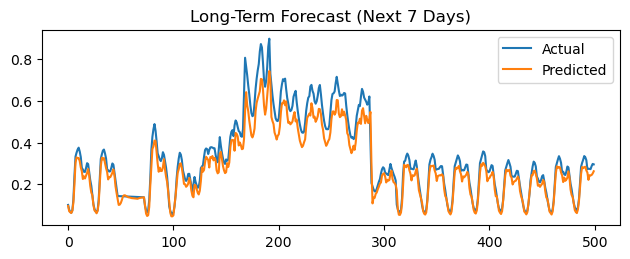

In [14]:
# Long-Term (first 500 hours for clarity)
plt.subplot(2,1,2)
plt.plot(y_test[:500].flatten(), label="Actual")
plt.plot(y_pred[:500].flatten(), label="Predicted")
plt.title("Long-Term Forecast (Next 7 Days)")
plt.legend()

plt.tight_layout()
plt.show()

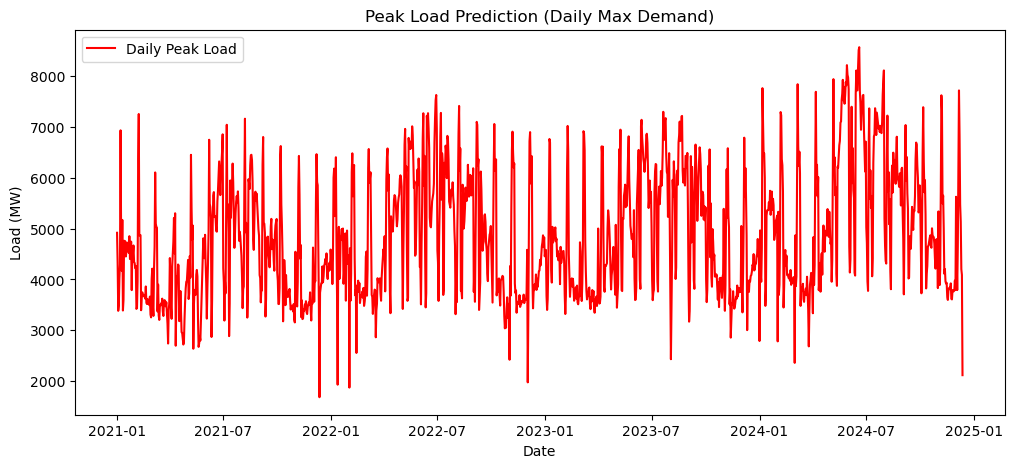

In [15]:
# Peak Load Prediction
daily_peak = df['Power demand'].resample('D').max()

plt.figure(figsize=(12,5))
plt.plot(daily_peak, label="Daily Peak Load", color="red")
plt.title("Peak Load Prediction (Daily Max Demand)")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.legend()
plt.show()


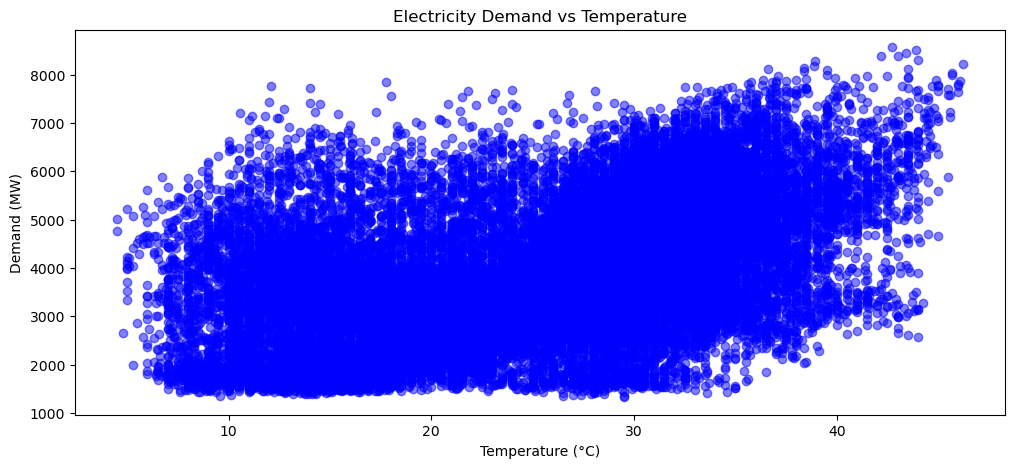

In [16]:
# Load vs Temperature
plt.figure(figsize=(12,5))
plt.scatter(df['temp'], df['Power demand'], alpha=0.5, c='blue')
plt.title("Electricity Demand vs Temperature")
plt.xlabel("Temperature (°C)")
plt.ylabel("Demand (MW)")
plt.show()

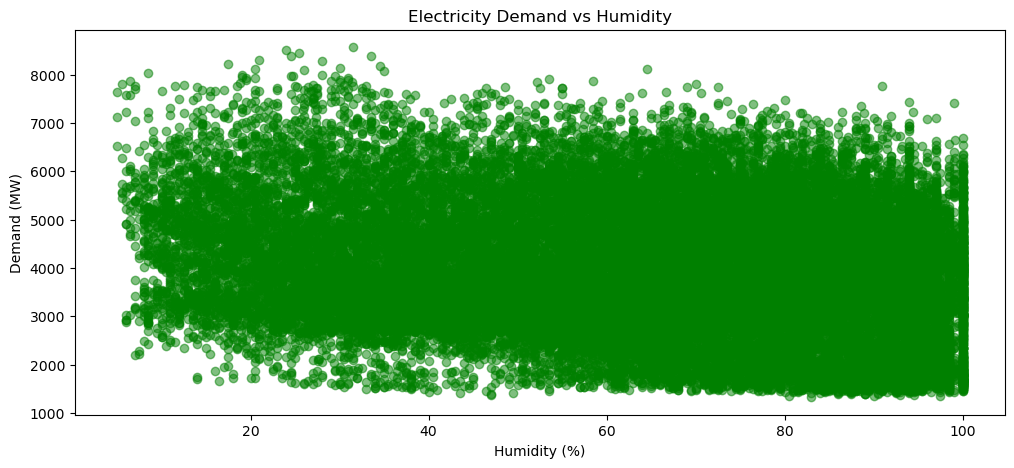

In [17]:
# Load vs Humidity
plt.figure(figsize=(12,5))
plt.scatter(df['rhum'], df['Power demand'], alpha=0.5, c='green')
plt.title("Electricity Demand vs Humidity")
plt.xlabel("Humidity (%)")
plt.ylabel("Demand (MW)")
plt.show()

In [18]:
df.keys()


Index(['Unnamed: 0', 'Power demand', 'temp', 'dwpt', 'rhum', 'wdir', 'wspd',
       'pres', 'year', 'month', 'day', 'hour', 'minute', 'moving_avg_3',
       'dayofweek'],
      dtype='object')

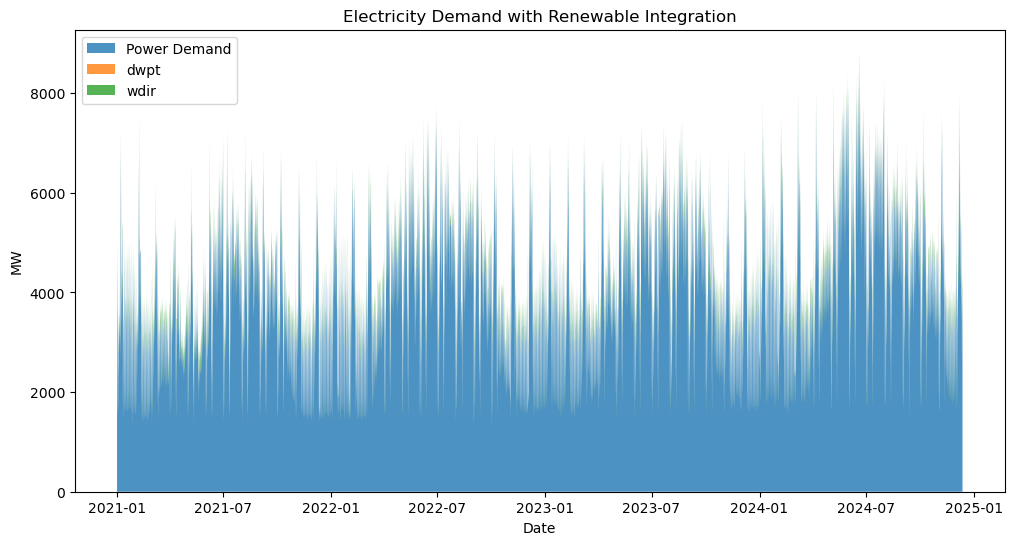

In [19]:
plt.figure(figsize=(12,6))
plt.stackplot(df.index, df['Power demand'], df['dwpt'], df['wdir'],
              labels=['Power Demand','dwpt','wdir'], alpha=0.8)
plt.title("Electricity Demand with Renewable Integration")
plt.xlabel("Date")
plt.ylabel("MW")
plt.legend(loc="upper left")
plt.show()


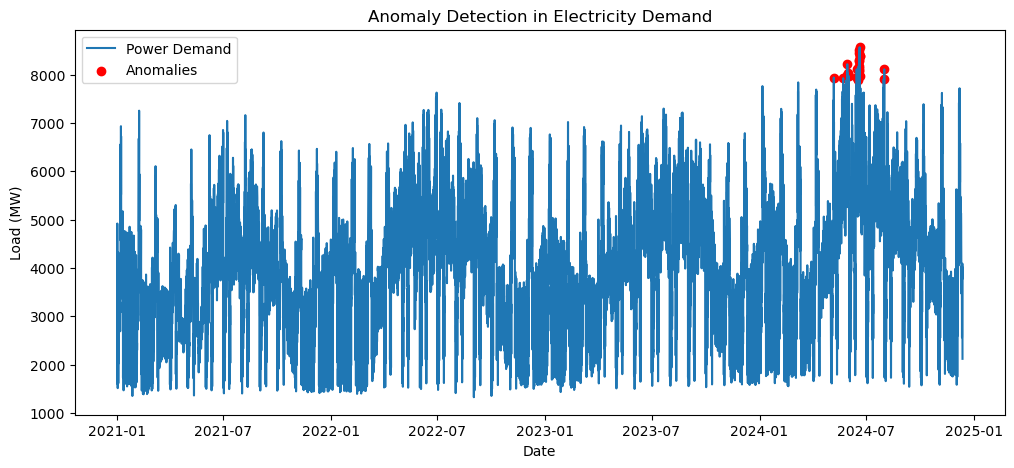

In [20]:
# Simple anomaly detection using Z-score
demand_mean, demand_std = df['Power demand'].mean(), df['Power demand'].std()
z_scores = (df['Power demand'] - demand_mean) / demand_std
anomalies = df[np.abs(z_scores) > 3]  # points beyond 3σ

plt.figure(figsize=(12,5))
plt.plot(df.index, df['Power demand'], label="Power Demand")
plt.scatter(anomalies.index, anomalies['Power demand'], color="red", label="Anomalies")
plt.title("Anomaly Detection in Electricity Demand")
plt.xlabel("Date")
plt.ylabel("Load (MW)")
plt.legend()
plt.show()


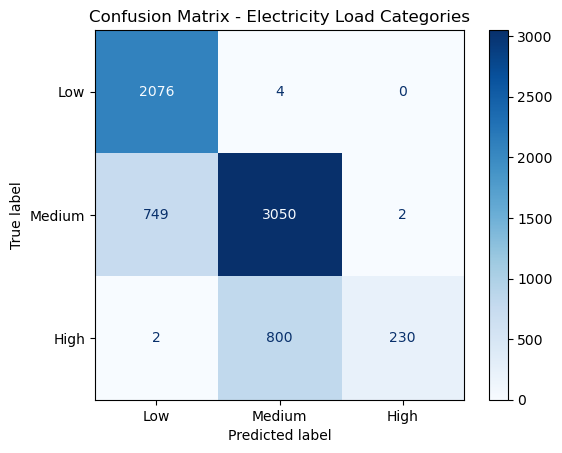

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Step 1: Define demand categories
def categorize_load(value):
    if value < 0.33:
        return "Low"
    elif value < 0.66:
        return "Medium"
    else:
        return "High"

# Scale back predictions to 0-1 if needed (assuming you already scaled with MinMaxScaler)
y_test = [categorize_load(v) for v in y_test]
y_pred = [categorize_load(v) for v in y_pred]

# Step 2: Build confusion matrix
labels = ["Low", "Medium", "High"]
cm = confusion_matrix(y_test, y_pred, labels=labels)

# Step 3: Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Electricity Load Categories")
plt.show()


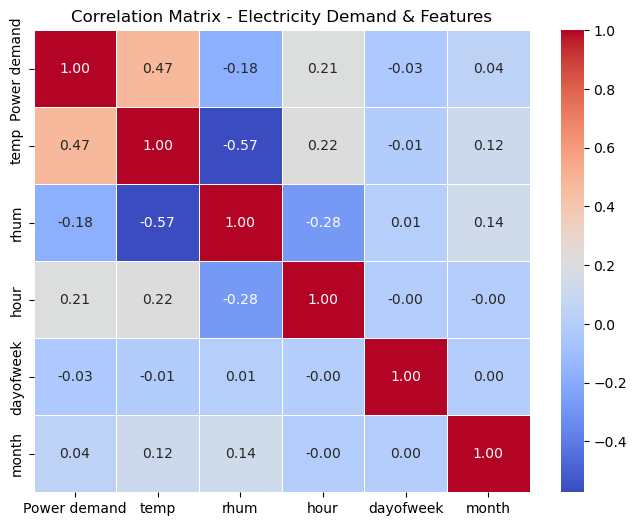

In [22]:
import seaborn as sns

# Compute correlation
corr = df[['Power demand', 'temp', 'rhum', 'hour', 'dayofweek', 'month']].corr()

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix - Electricity Demand & Features")
plt.show()


In [23]:
df.describe().T.style.background_gradient(cmap = sns.color_palette("ch:s=-.2,r=.6", as_cmap=True))

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,34585.000000,196013.855956,113442.489156,2.500000,97963.500000,194286.500000,295286.500000,393436.000000
Power demand,34585.000000,3959.337889,1307.698570,1324.560833,3050.839167,3833.422500,4885.152727,8565.135000
temp,34585.000000,25.477704,7.954463,4.500000,19.600000,27.000000,31.050000,46.200000
dwpt,34585.000000,16.371523,7.300359,-8.600000,10.600000,15.450000,23.750000,30.050000
rhum,34585.000000,63.705413,24.447968,5.000000,44.500000,67.000000,85.000000,100.000000
wdir,34585.000000,161.903883,108.125921,0.000000,75.000000,145.000000,265.000000,360.000000
wspd,34585.000000,7.776618,5.316825,0.000000,3.800000,7.600000,11.200000,41.700000
pres,34585.000000,1008.936030,6.890390,990.800000,1003.100000,1008.550000,1015.000000,1027.000000
year,34585.000000,2022.479933,1.111615,2021.000000,2021.000000,2022.000000,2023.000000,2024.000000
month,34585.000000,6.447072,3.411361,1.000000,3.000000,6.000000,9.000000,12.000000


In [24]:
df.isna().sum()

Unnamed: 0      0
Power demand    0
temp            0
dwpt            0
rhum            0
wdir            0
wspd            0
pres            0
year            0
month           0
day             0
hour            0
minute          0
moving_avg_3    0
dayofweek       0
dtype: int64

In [25]:
categorical_val = []
continous_val = []
for column in df.columns:
    print('==============================')
    print(f"{column} : {df[column].unique()}")
    if len(df[column].unique()) <= 10:
        categorical_val.append(column)
    else:
        continous_val.append(column)

Unnamed: 0 : [2.50000e+00 1.15000e+01 2.35000e+01 ... 3.93428e+05 3.93432e+05
 3.93436e+05]
Power demand : [1975.54166667 1805.59       1665.91416667 ... 3171.26666667 2645.12904762
 2118.99142857]
temp : [ 8.          7.5         7.         ... 12.96666667 12.63333333
 12.3       ]
dwpt : [ 6.9         6.25        6.3        ... 11.68333333  9.225
  9.2875    ]
rhum : [93.         92.         95.5        ... 68.28571429 73.6
 67.33333333]
wdir : [  0.          55.         125.         ... 264.75       263.66666667
 266.33333333]
wspd : [0.    4.7   8.5   ... 5.55  3.225 2.75 ]
pres : [1017.         1018.05       1018.2        ... 1018.3        1017.6
 1019.06666667]
year : [2021.         2022.         2023.         2023.03846154 2023.07692308
 2023.11538462 2023.15384615 2023.19230769 2023.23076923 2023.26923077
 2023.30769231 2023.34615385 2023.38461538 2023.42307692 2023.46153846
 2023.5        2023.53846154 2023.57692308 2023.61538462 2023.65384615
 2023.69230769 2023.73076923 2023

In [28]:
!jupyter nbconvert --to script Electricity_Load_Forecasting.ipynb




[NbConvertApp] Converting notebook Electricity_Load_Forecasting.ipynb to script
[NbConvertApp] Writing 6293 bytes to Electricity_Load_Forecasting.py


In [ ]:
!streamlit run Electricity_Load_Forecasting.py
